In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds


In [2]:
# For brevity I decided to reuse this small image dataset that was available with tfds
# For an example of raw data preprocessing I point to my recent...
IMGDS = 'aflw2k3d'
assert IMGDS in tfds.list_builders(), \
  IMGDS + ' dataset not found in tfds! This was tested with tensorflow-datasets-2.1.0'
ds_builder = tfds.builder(IMGDS)
ds_builder.download_and_prepare()
ds_raw = ds_builder.as_dataset(split='train')


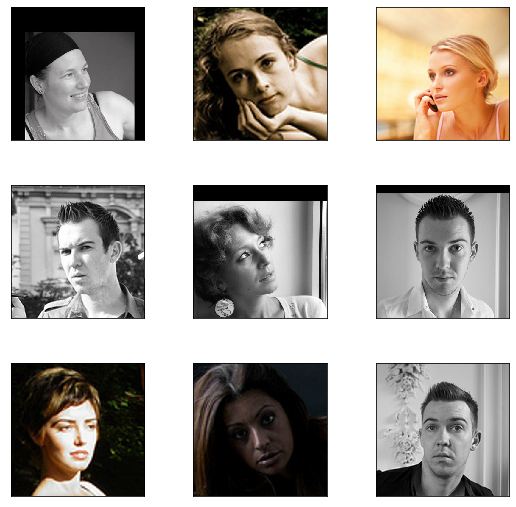

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
_, ds_info = tfds.load(IMGDS, with_info=True)
num_examples = ds_info.splits['train'].num_examples
fig = tfds.show_examples(ds_info, ds_raw)


In [4]:
def extract_images(features):
    return features['image']  # (450, 450, 3)

ds = ds_raw.map(extract_images).shuffle(num_examples)


In [5]:
def normalize(image, augment=False):
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.random_crop(image, size=[256, 256, 1]) # Random crop to 256x256
    if augment:
        image = tf.image.random_brightness(image, max_delta=0.05) # Random brightness
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32) 
    noisy_image = image + noise
    return noisy_image, image


augment_normalize = lambda img: normalize(img, augment=True)

batch_size = 32
num_test_examples = 100
num_train_examples = num_examples - num_test_examples
ds_train = ds.take(num_train_examples)
ds_test = ds.skip(num_train_examples)

augmented_train_batches = (
    ds_train
    .map(augment_normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_batches = (
    ds_test
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(1)
    .prefetch(tf.data.experimental.AUTOTUNE)
)


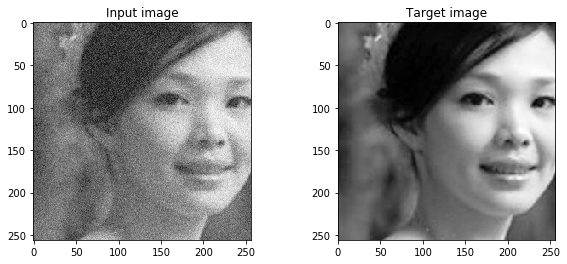

In [6]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)
for in_img, out_img in test_batches.take(1):
    ax1.imshow(in_img.numpy()[0, :, :, 0], cmap='Greys_r')
    ax1.set_title("Input image")
    ax2.imshow(out_img.numpy()[0, :, :, 0], cmap='Greys_r')
    ax2.set_title("Target image")


In [19]:
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import Input
from tensorflow.keras.models import Model

def make_model():
    i = Input(shape=(256, 256, 1))
    m = Conv2D(128, (3, 3), padding='same', dilation_rate=1, activation= None)(i)
    m = Activation('relu')(m)
    m = Conv2D(128, (3, 3), padding='same', dilation_rate=1, activation= None)(m)
    m = BatchNormalization()(m)
    m = Activation('relu')(m)
    #m = Conv2D(32, (3, 3), padding='same', dilation_rate=4, activation= None)(m)
    #m = BatchNormalization()(m)
    #m = Activation('relu')(m)
    #m = Conv2D(32, (3, 3), padding='same', dilation_rate=2, activation= None)(m)
    #m = BatchNormalization()(m)
    #m = Activation('relu')(m)
    o = Conv2D(1, (3, 3), padding='same', dilation_rate=1, activation= None)(m)
    o = i - o
    # TODO: use Sequential
    # TODO: use regularization to avoid overfitting
    # TODO: GRU output on sequence
    model = Model(inputs=i, outputs=o)
    model.compile(optimizer='adam', loss=tf.losses.MeanSquaredError())
    return model


In [22]:
model = make_model()

model = tf.keras.models.load_model('model_err0.00050.h5')



In [18]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='model_err{loss:.5f}.h5',
        save_best_only=True,
        save_freq='epoch',
        monitor='loss',
        mode='min',
        verbose=0),
]

history = model.fit(
    augmented_train_batches.repeat(),
    epochs=2, verbose=1,
    steps_per_epoch=num_train_examples // batch_size,
    callbacks=callbacks,
)


Train for 59 steps
Epoch 1/2
59/59 [==============================] - 1138s 19s/step - loss: 0.1459
Epoch 2/2
59/59 [==============================] - 1120s 19s/step - loss: 0.0015


In [ ]:
results = model.evaluate(test_batches, verbose=1)
print("Mean Squared Error on the test set", results)


<class 'numpy.ndarray'> (1, 256, 256, 1)


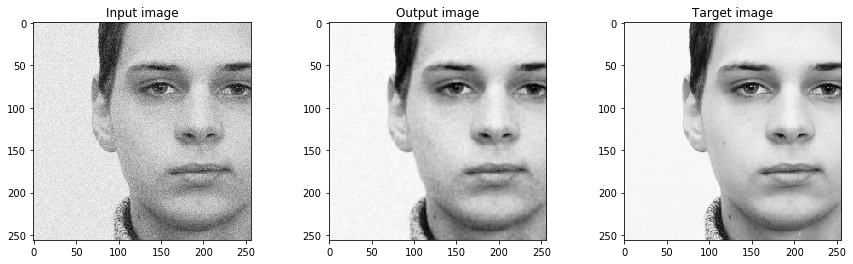

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), ncols=3)
for in_img, out_img in test_batches.repeat().take(1):
    prediction = model.predict(in_img)
    print(type(prediction), prediction.shape)
    ax1.imshow(in_img.numpy()[0, :, :, 0], cmap='Greys_r')
    ax1.set_title("Input image")
    ax2.imshow(prediction[0, :, :, 0], cmap='Greys_r')
    ax2.set_title("Output image")
    ax3.imshow(out_img.numpy()[0, :, :, 0], cmap='Greys_r')
    ax3.set_title("Target image")
